In [ ]:
# Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset Distribution:
  - squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155 images
  - normal: 148 images
  - large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115 images
  - adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 195 images


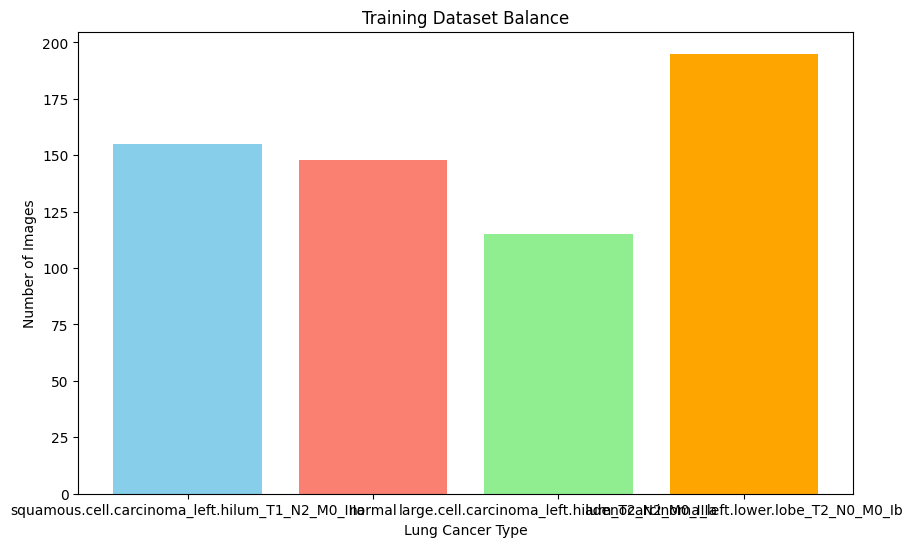

In [ ]:

import os
import matplotlib.pyplot as plt

# The path we verified earlier
data_dir = "/content/drive/MyDrive/Lung Cancer-CT Scan/Data/train"

# Get class names and counts
classes = os.listdir(data_dir)
counts = {}

for cls in classes:
    path = os.path.join(data_dir, cls)
    if os.path.isdir(path):
        counts[cls] = len(os.listdir(path))

# Print the numbers
print("Dataset Distribution:")
for cls, count in counts.items():
    print(f"  - {cls}: {count} images")

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color=['skyblue', 'salmon', 'lightgreen', 'orange'])
plt.xlabel('Lung Cancer Type')
plt.ylabel('Number of Images')
plt.title('Training Dataset Balance')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import os


data_dir = "/content/drive/MyDrive/Lung Cancer-CT Scan/Data"

# 2. ADVANCED DATA AUGMENTATION
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# --- 3. DATALOADERS ---

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])

                  for x in ['train', 'valid', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=(x=='train'))

              for x in ['train', 'valid', 'test']}



class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44285 sha256=cd162b08275b9f0e6801e9351bff9b9da593c7cb78be6ceb3e663688a121c999
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# --------------------Efficent Net 2.0 (CBAM)---------------------------------------
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_planes, in_planes // ratio, bias=False),
            nn.ReLU(),
            nn.Linear(in_planes // ratio, in_planes, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x).view(x.size(0), -1))
        max_out = self.fc(self.max_pool(x).view(x.size(0), -1))
        return self.sigmoid(avg_out + max_out).view(x.size(0), x.size(1), 1, 1)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        res = torch.cat([avg_out, max_out], dim=1)
        res = self.conv1(res)
        return self.sigmoid(res)

# --- 2. INTEGRATE CBAM INTO EFFICIENTNET ---
class EfficientNet_CBAM(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNet_CBAM, self).__init__()

        base_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.features = base_model.features

        # CBAM Layers
        self.channel_attn = ChannelAttention(1280)
        self.spatial_attn = SpatialAttention()

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=0.4),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.features(x)

        x = x * self.channel_attn(x)
        x = x * self.spatial_attn(x)
        # Classify
        x = self.classifier(x)
        return x


class_names = image_datasets['train'].classes
num_classes = len(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNet_CBAM(num_classes=len(class_names)).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
print("🚀 EfficientNet + CBAM initialized for Lung Cancer/MRI detection.")

class_weights = torch.tensor([1.0, 1.69, 1.31, 1.25]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

🚀 EfficientNet + CBAM initialized for Lung Cancer/MRI detection.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import os
import copy

# --- 1. EARLY STOPPING CLASS ---
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        '''Saves model when validation loss decreases.'''
        torch.save(model.state_dict(), self.path)


# Initialize Early Stopping
early_stopper = EarlyStopping(patience=7, path='/content/drive/MyDrive/lung_cancer_best.pth')

# --- 3. TRAINING LOOP ---
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0

    # Training Phase
    train_pbar = tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs} [Train]", unit="batch")
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss = running_loss / len(image_datasets['train'])
    train_acc = running_corrects.double() / len(image_datasets['train'])

    # Validation Phase (Required for Early Stopping)
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(image_datasets['valid'])
    val_acc = val_corrects.double() / len(image_datasets['valid'])

    print(f"Epoch {epoch+1} Results: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    # Check Early Stopping
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print(" Early stopping triggered. Training halted.")
        break

# Load the best model weights found during training
model.load_state_dict(torch.load('/content/drive/MyDrive/lung_cancer_best.pth'))
print("🏆 Training Finished. Best model restored.")

Epoch 1/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 1 Results: Train Acc: 0.3312 | Val Acc: 0.2222 | Val Loss: 1.3876


Epoch 2/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 2 Results: Train Acc: 0.3964 | Val Acc: 0.3056 | Val Loss: 1.3855


Epoch 3/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 3 Results: Train Acc: 0.4747 | Val Acc: 0.4028 | Val Loss: 1.3750


Epoch 4/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 4 Results: Train Acc: 0.4910 | Val Acc: 0.4722 | Val Loss: 1.3597


Epoch 5/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 5 Results: Train Acc: 0.4992 | Val Acc: 0.4722 | Val Loss: 1.3538


Epoch 6/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 6 Results: Train Acc: 0.5008 | Val Acc: 0.5278 | Val Loss: 1.3443


Epoch 7/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 7 Results: Train Acc: 0.5449 | Val Acc: 0.5417 | Val Loss: 1.3315


Epoch 8/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 8 Results: Train Acc: 0.5922 | Val Acc: 0.5417 | Val Loss: 1.3197


Epoch 9/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 9 Results: Train Acc: 0.6036 | Val Acc: 0.5417 | Val Loss: 1.3069


Epoch 10/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 10 Results: Train Acc: 0.5987 | Val Acc: 0.5417 | Val Loss: 1.2898


Epoch 11/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 11 Results: Train Acc: 0.5824 | Val Acc: 0.5278 | Val Loss: 1.2630


Epoch 12/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 12 Results: Train Acc: 0.6052 | Val Acc: 0.5556 | Val Loss: 1.2408


Epoch 13/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 13 Results: Train Acc: 0.6199 | Val Acc: 0.5694 | Val Loss: 1.1999


Epoch 14/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 14 Results: Train Acc: 0.6150 | Val Acc: 0.5972 | Val Loss: 1.1727


Epoch 15/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 15 Results: Train Acc: 0.6052 | Val Acc: 0.5833 | Val Loss: 1.1340


Epoch 16/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 16 Results: Train Acc: 0.6819 | Val Acc: 0.5972 | Val Loss: 1.1190


Epoch 17/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 17 Results: Train Acc: 0.6378 | Val Acc: 0.5972 | Val Loss: 1.0998


Epoch 18/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 18 Results: Train Acc: 0.6591 | Val Acc: 0.5972 | Val Loss: 1.0837


Epoch 19/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 19 Results: Train Acc: 0.6737 | Val Acc: 0.6111 | Val Loss: 1.0605


Epoch 20/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 20 Results: Train Acc: 0.6786 | Val Acc: 0.6250 | Val Loss: 1.0551


Epoch 21/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 21 Results: Train Acc: 0.6803 | Val Acc: 0.6250 | Val Loss: 1.0381


Epoch 22/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 22 Results: Train Acc: 0.6623 | Val Acc: 0.6528 | Val Loss: 1.0160


Epoch 23/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 23 Results: Train Acc: 0.7015 | Val Acc: 0.6528 | Val Loss: 1.0026


Epoch 24/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 24 Results: Train Acc: 0.7129 | Val Acc: 0.6667 | Val Loss: 0.9792


Epoch 25/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 25 Results: Train Acc: 0.7129 | Val Acc: 0.6389 | Val Loss: 0.9747


Epoch 26/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 26 Results: Train Acc: 0.7357 | Val Acc: 0.6667 | Val Loss: 0.9466


Epoch 27/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 27 Results: Train Acc: 0.7471 | Val Acc: 0.6944 | Val Loss: 0.9223


Epoch 28/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 28 Results: Train Acc: 0.7488 | Val Acc: 0.6806 | Val Loss: 0.8956


Epoch 29/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 29 Results: Train Acc: 0.7667 | Val Acc: 0.6806 | Val Loss: 0.8748


Epoch 30/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 30 Results: Train Acc: 0.7635 | Val Acc: 0.7361 | Val Loss: 0.8475


Epoch 31/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 31 Results: Train Acc: 0.7732 | Val Acc: 0.7083 | Val Loss: 0.8412


Epoch 32/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 32 Results: Train Acc: 0.7749 | Val Acc: 0.7500 | Val Loss: 0.8050


Epoch 33/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 33 Results: Train Acc: 0.7945 | Val Acc: 0.7222 | Val Loss: 0.7806


Epoch 34/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 34 Results: Train Acc: 0.7798 | Val Acc: 0.7222 | Val Loss: 0.8014
EarlyStopping counter: 1 out of 7


Epoch 35/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 35 Results: Train Acc: 0.7928 | Val Acc: 0.7361 | Val Loss: 0.7592


Epoch 36/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 36 Results: Train Acc: 0.8042 | Val Acc: 0.7500 | Val Loss: 0.7348


Epoch 37/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 37 Results: Train Acc: 0.8042 | Val Acc: 0.7778 | Val Loss: 0.6993


Epoch 38/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 38 Results: Train Acc: 0.7928 | Val Acc: 0.7778 | Val Loss: 0.6949


Epoch 39/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 39 Results: Train Acc: 0.8352 | Val Acc: 0.7778 | Val Loss: 0.6556


Epoch 40/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 40 Results: Train Acc: 0.8271 | Val Acc: 0.7917 | Val Loss: 0.6319


Epoch 41/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 41 Results: Train Acc: 0.8418 | Val Acc: 0.8056 | Val Loss: 0.6310
EarlyStopping counter: 1 out of 7


Epoch 42/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 42 Results: Train Acc: 0.8401 | Val Acc: 0.7917 | Val Loss: 0.6225


Epoch 43/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 43 Results: Train Acc: 0.8467 | Val Acc: 0.7778 | Val Loss: 0.5901


Epoch 44/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 44 Results: Train Acc: 0.8483 | Val Acc: 0.7917 | Val Loss: 0.5733


Epoch 45/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 45 Results: Train Acc: 0.8597 | Val Acc: 0.7917 | Val Loss: 0.5687


Epoch 46/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 46 Results: Train Acc: 0.8662 | Val Acc: 0.7917 | Val Loss: 0.5787
EarlyStopping counter: 1 out of 7


Epoch 47/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 47 Results: Train Acc: 0.8564 | Val Acc: 0.7917 | Val Loss: 0.5187


Epoch 48/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 48 Results: Train Acc: 0.8613 | Val Acc: 0.8056 | Val Loss: 0.5136


Epoch 49/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 49 Results: Train Acc: 0.8744 | Val Acc: 0.8194 | Val Loss: 0.5070


Epoch 50/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 50 Results: Train Acc: 0.8564 | Val Acc: 0.8194 | Val Loss: 0.5027


Epoch 51/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 51 Results: Train Acc: 0.8825 | Val Acc: 0.8056 | Val Loss: 0.5239
EarlyStopping counter: 1 out of 7


Epoch 52/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 52 Results: Train Acc: 0.8711 | Val Acc: 0.8056 | Val Loss: 0.4548


Epoch 53/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 53 Results: Train Acc: 0.8825 | Val Acc: 0.8056 | Val Loss: 0.5008
EarlyStopping counter: 1 out of 7


Epoch 54/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 54 Results: Train Acc: 0.8923 | Val Acc: 0.8056 | Val Loss: 0.4865
EarlyStopping counter: 2 out of 7


Epoch 55/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 55 Results: Train Acc: 0.8793 | Val Acc: 0.8194 | Val Loss: 0.4794
EarlyStopping counter: 3 out of 7


Epoch 56/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 56 Results: Train Acc: 0.9070 | Val Acc: 0.8333 | Val Loss: 0.4744
EarlyStopping counter: 4 out of 7


Epoch 57/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 57 Results: Train Acc: 0.8630 | Val Acc: 0.8194 | Val Loss: 0.4871
EarlyStopping counter: 5 out of 7


Epoch 58/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 58 Results: Train Acc: 0.9005 | Val Acc: 0.8333 | Val Loss: 0.4531


Epoch 59/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 59 Results: Train Acc: 0.8646 | Val Acc: 0.8611 | Val Loss: 0.4323


Epoch 60/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 60 Results: Train Acc: 0.8989 | Val Acc: 0.8333 | Val Loss: 0.4538
EarlyStopping counter: 1 out of 7


Epoch 61/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 61 Results: Train Acc: 0.8907 | Val Acc: 0.8333 | Val Loss: 0.4424
EarlyStopping counter: 2 out of 7


Epoch 62/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 62 Results: Train Acc: 0.9005 | Val Acc: 0.8333 | Val Loss: 0.4291


Epoch 63/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 63 Results: Train Acc: 0.8972 | Val Acc: 0.8472 | Val Loss: 0.4643
EarlyStopping counter: 1 out of 7


Epoch 64/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 64 Results: Train Acc: 0.9054 | Val Acc: 0.8333 | Val Loss: 0.4312
EarlyStopping counter: 2 out of 7


Epoch 65/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 65 Results: Train Acc: 0.8923 | Val Acc: 0.8333 | Val Loss: 0.4305
EarlyStopping counter: 3 out of 7


Epoch 66/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 66 Results: Train Acc: 0.9119 | Val Acc: 0.8472 | Val Loss: 0.4362
EarlyStopping counter: 4 out of 7


Epoch 67/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 67 Results: Train Acc: 0.9005 | Val Acc: 0.8333 | Val Loss: 0.4189


Epoch 68/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 68 Results: Train Acc: 0.9152 | Val Acc: 0.8472 | Val Loss: 0.4109


Epoch 69/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 69 Results: Train Acc: 0.9266 | Val Acc: 0.8611 | Val Loss: 0.4011


Epoch 70/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 70 Results: Train Acc: 0.9201 | Val Acc: 0.8611 | Val Loss: 0.3920


Epoch 71/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 71 Results: Train Acc: 0.9103 | Val Acc: 0.8611 | Val Loss: 0.3898


Epoch 72/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 72 Results: Train Acc: 0.9152 | Val Acc: 0.8611 | Val Loss: 0.3988
EarlyStopping counter: 1 out of 7


Epoch 73/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 73 Results: Train Acc: 0.9021 | Val Acc: 0.8472 | Val Loss: 0.3947
EarlyStopping counter: 2 out of 7


Epoch 74/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 74 Results: Train Acc: 0.9054 | Val Acc: 0.8750 | Val Loss: 0.3906
EarlyStopping counter: 3 out of 7


Epoch 75/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 75 Results: Train Acc: 0.9168 | Val Acc: 0.8750 | Val Loss: 0.4115
EarlyStopping counter: 4 out of 7


Epoch 76/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 76 Results: Train Acc: 0.9184 | Val Acc: 0.8611 | Val Loss: 0.3921
EarlyStopping counter: 5 out of 7


Epoch 77/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 77 Results: Train Acc: 0.9266 | Val Acc: 0.8611 | Val Loss: 0.3931
EarlyStopping counter: 6 out of 7


Epoch 78/100 [Train]:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch 78 Results: Train Acc: 0.9266 | Val Acc: 0.8750 | Val Loss: 0.4296
EarlyStopping counter: 7 out of 7
 Early stopping triggered. Training halted.
🏆 Training Finished. Best model restored.


In [ ]:
# --- 6. FINAL TEST EVALUATION ---
def evaluate_test_set():
    model.eval()
    test_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test'], desc="Evaluating Test Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)

    test_acc = test_corrects.double() / len(image_datasets['test'])
    print(f"\n Final Test Accuracy: {test_acc:.4f}")

evaluate_test_set()

Evaluating Test Set:   0%|          | 0/10 [00:00<?, ?it/s]


 Final Test Accuracy: 0.9048


In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44285 sha256=f4ff1800b9a86d9178ef62d53627410b74fa205eb3cdef089250aab53cf16412
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


Please select a CT scan or MRI image from your computer...


Saving lung_cancer.png to lung_cancer.png


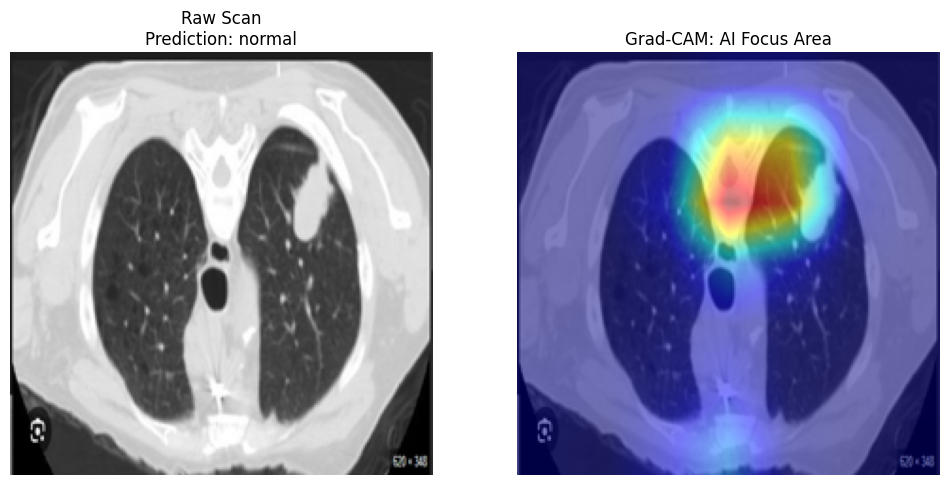

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from google.colab import files
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def upload_and_visualize_simple(model, class_names):

    print("Please select a CT scan or MRI image from your computer...")
    uploaded = files.upload() #
    for fn in uploaded.keys():
        img_path = fn


    img = Image.open(img_path).convert('RGB')
    rgb_img = np.array(img.resize((224, 224))).astype(np.float32) / 255.0

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Model Prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, preds = torch.max(output, 1)
        predicted_class = class_names[preds.item()]

    # 4. Grad-CAM (Targeting the end of the feature backbone)
    target_layers = [model.features[-1]] #

    with GradCAM(model=model, target_layers=target_layers) as cam:

        grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # 5. Display the Results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title(f"Raw Scan\nPrediction: {predicted_class}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM: AI Focus Area")
    plt.axis('off')

    plt.show()

upload_and_visualize_simple(model, class_names)

In [ ]:
import torch
import os

# Define the target folder path from your Drive
# Note: Ensure the folder name matches exactly (case-sensitive)
save_path = "/content/drive/MyDrive/Vega Hackathon Dataset"

# 1. Save ONLY the weights (Recommended for flexibility)
weights_filename = "best_efficientnet_weights.pth"
torch.save(model.state_dict(), os.path.join(save_path, weights_filename))

# 2. Save the ENTIRE model (Architecture + Weights)
model_filename = "best_efficientnet_full_model.pth"
torch.save(model, os.path.join(save_path, model_filename))

print(f" Success! Model saved to: {save_path}")

 Success! Model saved to: /content/drive/MyDrive/Vega Hackathon Dataset


In [4]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_lung_cancer_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 1. Classification Report (Precision, Recall, F1-Score)
    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # 2. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Lung Cancer Detection: Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy_score(all_labels, all_preds)

In [5]:
val_acc = evaluate_lung_cancer_model(
        model,
        image_datasets['Validation'], # Or wherever your val loader is stored
        device,
        class_names
    )

NameError: name 'model' is not defined

In [6]:
# Check if variables exist
try:
    print(f"Model type: {type(model)}")
    print(f"Classes: {class_names}")
except NameError as e:
    print(f"Variable missing: {e}")

Variable missing: name 'model' is not defined


In [7]:
import torch
import os

# 1. Mount Drive if you haven't already
from google.colab import drive
drive.mount('/content/drive')

# 2. Set the device to CPU if GPU is unavailable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 3. Initialize your Model Architecture
# (Must be the exact same class/structure used during training)
# model = YourLungCancerModelClass()

# 4. Load the saved weights
checkpoint_path = '/content/drive/MyDrive/Vega Hackathon Dataset/lungcancer_efficientcbam.pth'

if os.path.exists(checkpoint_path):
    # 'map_location' allows loading GPU-saved weights onto a CPU
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    print("Lung cancer weights loaded successfully!")


Mounted at /content/drive
Using device: cpu


In [8]:
import torch
import os

# 1. Define the device
device = torch.device('cpu')

# 2. Path to your saved weights in Drive
# Update this if your file name is different (e.g., 'best_lung_model.pth')
model_path = '/content/drive/MyDrive/Vega Hackathon Dataset/lungcancer_efficientcbam.pth'

# 3. Load the weights
if os.path.exists(model_path):
    # Load onto CPU specifically
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print("EfficientNet + CBAM weights loaded successfully on CPU!", flush=True)
else:
    print(f"Could not find model at: {model_path}", flush=True)

Could not find model at: /content/drive/MyDrive/Vega Hackathon Dataset/lungcancer_efficientcbam.pth
